# Evaluation Pipeline Testing Notebook
## Reasoning Distillation Project

This notebook performs **final evaluation on the TEST SET** for:

1. Individual metrics (Accuracy, ROUGE, BERTScore, Faithfulness)
2. Full evaluation pipeline on Test Set
3. Error analysis and confusion matrix
4. Per-label evaluation
5. Model comparison
6. Batch evaluation
7. Results visualization


In [1]:
# Setup
import sys
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from src.data.data_loader import TeacherDataLoader
from src.data.preprocessor import ReasoningPreprocessor, PreprocessConfig
from src.data.dataset import ESNLIDataset, create_dataloaders

from src.models.student import StudentModel, StudentConfig

from src.evaluation.metrics import (
    MetricsConfig,
    format_metrics
)

from src.evaluation.evaluator import (
    EvaluationConfig,
    Evaluator,
    BatchEvaluator,
)

In [2]:
# Set device (GPU or CPU)
# This determines where models and tensors will be loaded during training
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Prepare Test Data and Model

In [3]:
# Load test data
print("=" * 70)
print("LOADING TEST DATA")
print("=" * 70)

loader = TeacherDataLoader()
esnli_data = loader.load_esnli()

# Use TEST SET for final evaluation
test_subset = esnli_data['test']


print(f"\n✓ Test samples: {len(test_subset)}")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


LOADING TEST DATA


INFO:src.data.data_loader:✓ Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]



✓ Test samples: 9824


In [4]:
# Create dataset and dataloader
preprocess_config = PreprocessConfig(
    model_name="google/flan-t5-small",
    max_source_length=128,
    max_target_length=64
)

preprocessor = ReasoningPreprocessor(preprocess_config)
test_dataset = ESNLIDataset(test_subset, preprocessor, use_cache=True)

test_loader = create_dataloaders(
    test_dataset,
    batch_size=8,
    num_workers=0,
    pad_token_id=preprocessor.tokenizer.pad_token_id,
    shuffle_train=False
)

print(f"✓ Test batches: {len(test_loader)}")

INFO:src.data.preprocessor:Loading tokenizer: google/flan-t5-small
INFO:src.data.dataset:Initialized ESNLIDataset with 9824 samples


✓ Test batches: 1228


In [5]:
# Load model from checkpoint
print("\n" + "=" * 70)
print("LOADING MODEL FROM CHECKPOINT")
print("=" * 70)

import zipfile

# Path to checkpoint
checkpoint_dir = Path("../experiments/distillation")
model_zip = checkpoint_dir / "best_model.zip"
model_dir = checkpoint_dir / "best_model"

# Extract if needed
if model_zip.exists() and not model_dir.exists():
    print(f"Extracting model from {model_zip}...")
    with zipfile.ZipFile(model_zip, 'r') as zip_ref:
        zip_ref.extractall(checkpoint_dir)
    print("✓ Extracted successfully")

# Load model from checkpoint
if model_dir.exists():
    student_config = StudentConfig(
        max_source_length=128,
        max_target_length=64,
        device=device,
        num_beams=4
    )
    
    student = StudentModel.load_model(str(model_dir), student_config)
    print(f"\n✓ Model loaded from: {model_dir}")
    print(f"✓ Parameters: {student.count_parameters():,}")
else:
    print(f"ERROR: Model directory not found: {model_dir}")
    print(f"  Make sure best_model.zip is in {checkpoint_dir}")


LOADING MODEL FROM CHECKPOINT
Extracting model from ../experiments/distillation/best_model.zip...


INFO:src.models.student:Loading model from ../experiments/distillation/best_model
INFO:src.models.student:Initializing student model: ../experiments/distillation/best_model


✓ Extracted successfully


The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152



✓ Model loaded from: ../experiments/distillation/best_model
✓ Parameters: 76,961,152


## 3. Test Full Evaluation Pipeline

In [6]:
# Create evaluator
print("=" * 70)
print("INITIALIZING EVALUATOR")
print("=" * 70)

eval_config = EvaluationConfig(
    metrics_config=MetricsConfig(
        compute_rouge=True,
        compute_bertscore=False,  # Skip BERTScore for speed
        compute_faithfulness=True
    ),
    num_beams=4,
    max_length=64,
    save_predictions=True,
    save_detailed_results=True,
    analyze_errors=True,
    num_error_examples=5,
    output_dir="../experiments/evaluation_test"
)

evaluator = Evaluator(student, eval_config)

print("\n✓ Evaluator initialized!")

INFO:src.evaluation.evaluator:Evaluator initialized with output dir: ../experiments/evaluation_test


INITIALIZING EVALUATOR

✓ Evaluator initialized!


In [7]:
# Run evaluation
print("\n" + "=" * 70)
print("RUNNING FULL EVALUATION")
print("=" * 70)

results = evaluator.evaluate(test_loader, split_name="test")

print("\n✓ Evaluation complete!")

INFO:src.evaluation.evaluator:Starting evaluation on test split...
INFO:src.evaluation.evaluator:Total batches: 1228



RUNNING FULL EVALUATION


Evaluating test: 100%|██████████| 1228/1228 [11:42<00:00,  1.75it/s]
INFO:src.evaluation.evaluator:Generation complete in 702.75s
INFO:src.evaluation.evaluator:Generated 9824 predictions
INFO:src.evaluation.evaluator:Computing metrics...
INFO:absl:Using default tokenizer.
INFO:src.evaluation.evaluator:Analyzing errors...
INFO:src.evaluation.evaluator:Saved metrics to ../experiments/evaluation_test/test_metrics.json
INFO:src.evaluation.evaluator:Saved predictions to ../experiments/evaluation_test/test_predictions.jsonl
INFO:src.evaluation.evaluator:Saved error analysis to ../experiments/evaluation_test/test_analysis.json
INFO:src.evaluation.evaluator:
INFO:src.evaluation.evaluator:Evaluation Results - test
INFO:src.evaluation.evaluator:======================================================================
INFO:src.evaluation.evaluator:  accuracy_contradiction: 0.8292
  accuracy_entailment: 0.8613
  accuracy_neutral: 0.6886
  eval_time_seconds: 702.7544
  faithfulness: 0.6423
  label_acc


✓ Evaluation complete!


In [8]:
# Display results
print("\n" + "=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)

metrics = results['metrics']
print("\nMetrics:")
print(format_metrics(metrics))

print(f"\nGenerated {len(results['predictions'])} predictions")
print(f"Evaluation time: {metrics['eval_time_seconds']:.2f}s")
print(f"Throughput: {metrics['samples_per_second']:.2f} samples/sec")


EVALUATION RESULTS

Metrics:
  accuracy_contradiction: 0.8292
  accuracy_entailment: 0.8613
  accuracy_neutral: 0.6886
  eval_time_seconds: 702.7544
  faithfulness: 0.6423
  label_accuracy: 0.7941
  loss: 1.2048
  rouge1: 0.4618
  rouge2: 0.2511
  rougeL: 0.4032
  samples_per_second: 13.9793
  valid_predictions: 9794

Generated 9824 predictions
Evaluation time: 702.75s
Throughput: 13.98 samples/sec


## 4. Analyze Predictions

In [9]:
# Display sample predictions
print("=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)

predictions = results['predictions']
references = results['references']
inputs = results['inputs']

for i in range(min(3, len(predictions))):
    print(f"\n{'='*70}")
    print(f"SAMPLE {i+1}")
    print(f"{'='*70}")
    print(f"\nInput:\n{inputs[i]}")
    print(f"\nReference:\n{references[i]}")
    print(f"\nPrediction:\n{predictions[i]}")

SAMPLE PREDICTIONS

SAMPLE 1

Input:
nli premise: This church choir sings to the masses as they sing joyous songs from the book at a church. hypothesis: The church has cracks in the ceiling.

Reference:
neutral explanation: Not all churches have cracks in the ceiling

Prediction:
contradiction explanation: The church cannot sing joyous songs from the book and have cracks in the ceiling at the same time.

SAMPLE 2

Input:
nli premise: This church choir sings to the masses as they sing joyous songs from the book at a church. hypothesis: The church is filled with song.

Reference:
entailment explanation: "Filled with song" is a rephrasing of the "choir sings to the masses."

Prediction:
entailment explanation: The church choir sings joyous songs from the book at a church is filled with song.

SAMPLE 3

Input:
nli premise: This church choir sings to the masses as they sing joyous songs from the book at a church. hypothesis: A choir singing at a baseball game.

Reference:
contradiction expl

## 5. Error Analysis

In [10]:
# Display error analysis
print("=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)

error_analysis = results['error_analysis']

if error_analysis:
    print(f"\nTotal errors: {error_analysis['total_errors']}")
    print(f"Error rate: {error_analysis['error_rate']:.2%}")
    
    # Display confusion matrix
    print("\n" + "=" * 70)
    print("CONFUSION MATRIX")
    print("=" * 70)
    
    confusion = error_analysis['confusion_matrix']
    
    # Create DataFrame for better display
    labels = ['entailment', 'neutral', 'contradiction']
    confusion_df = pd.DataFrame(
        [[confusion[true_label][pred_label] for pred_label in labels]
         for true_label in labels],
        index=labels,
        columns=labels
    )
    
    print("\n", confusion_df)
    
    # Sample errors
    print("\n" + "=" * 70)
    print("SAMPLE ERRORS")
    print("=" * 70)
    
    for i, error in enumerate(error_analysis['sample_errors'][:3], 1):
        print(f"\n--- Error {i} ---")
        print(f"Predicted: {error['predicted_label']}")
        print(f"True: {error['true_label']}")
        print(f"Input: {error['input'][:100]}...")
        print(f"Prediction: {error['prediction'][:100]}...")
else:
    print("\nNo error analysis available")

ERROR ANALYSIS

Total errors: 2017
Error rate: 20.53%

CONFUSION MATRIX

                entailment  neutral  contradiction
entailment           2901      319            148
neutral               381     2216            621
contradiction         220      328           2660

SAMPLE ERRORS

--- Error 1 ---
Predicted: contradiction
True: neutral
Input: nli premise: This church choir sings to the masses as they sing joyous songs from the book at a chur...
Prediction: contradiction explanation: The church cannot sing joyous songs from the book and have cracks in the ...

--- Error 2 ---
Predicted: neutral
True: entailment
Input: nli premise: A woman with a green headscarf, blue shirt and a very big grin. hypothesis: The woman i...
Prediction: neutral explanation: Just because a woman has a big grin does not mean she is happy....

--- Error 3 ---
Predicted: neutral
True: contradiction
Input: nli premise: A woman with a green headscarf, blue shirt and a very big grin. hypothesis: The woman h.

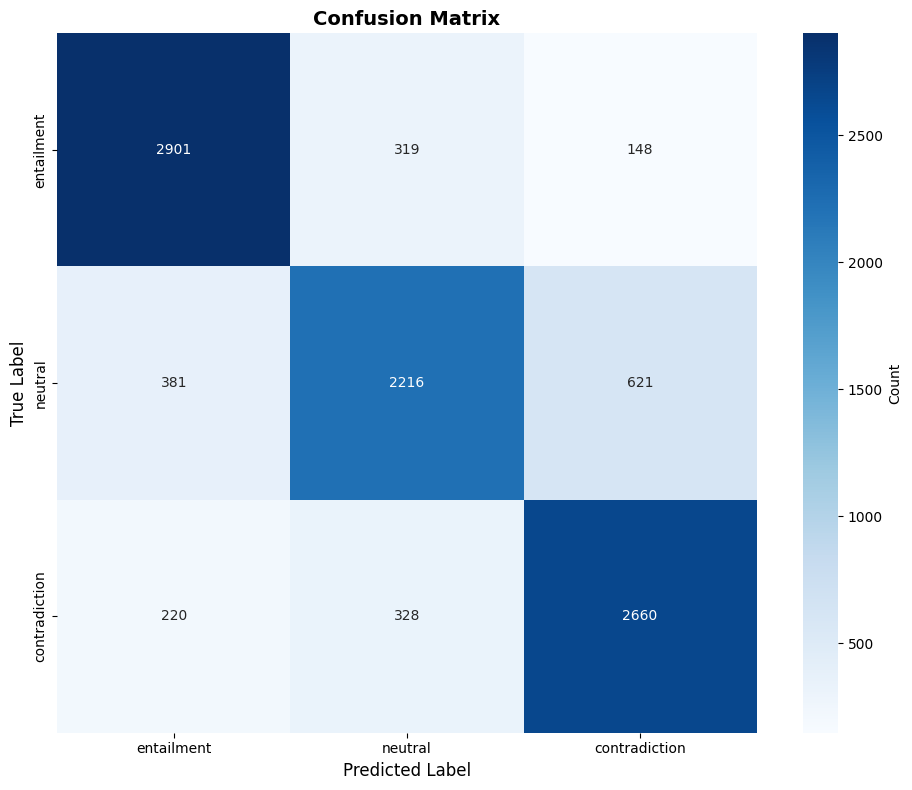

In [11]:
# Visualize confusion matrix
if error_analysis:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(
        confusion_df,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar_kws={'label': 'Count'},
        ax=ax
    )
    
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 6. Per-Label Evaluation

In [12]:
# Evaluate performance by label
print("=" * 70)
print("PER-LABEL EVALUATION")
print("=" * 70)

per_label_metrics = evaluator.evaluate_by_label(test_loader)

print("\n✓ Per-label evaluation complete!")

INFO:src.evaluation.evaluator:Evaluating by label...
INFO:src.evaluation.evaluator:Starting evaluation on by_label split...
INFO:src.evaluation.evaluator:Total batches: 1228


PER-LABEL EVALUATION


Evaluating by_label: 100%|██████████| 1228/1228 [11:44<00:00,  1.74it/s]
INFO:src.evaluation.evaluator:Generation complete in 704.13s
INFO:src.evaluation.evaluator:Generated 9824 predictions
INFO:src.evaluation.evaluator:Computing metrics...
INFO:absl:Using default tokenizer.
INFO:src.evaluation.evaluator:Analyzing errors...
INFO:src.evaluation.evaluator:Saved metrics to ../experiments/evaluation_test/by_label_metrics.json
INFO:src.evaluation.evaluator:Saved predictions to ../experiments/evaluation_test/by_label_predictions.jsonl
INFO:src.evaluation.evaluator:Saved error analysis to ../experiments/evaluation_test/by_label_analysis.json
INFO:src.evaluation.evaluator:
INFO:src.evaluation.evaluator:Evaluation Results - by_label
INFO:src.evaluation.evaluator:======================================================================
INFO:src.evaluation.evaluator:  accuracy_contradiction: 0.8292
  accuracy_entailment: 0.8613
  accuracy_neutral: 0.6886
  eval_time_seconds: 704.1271
  faithfulness


✓ Per-label evaluation complete!


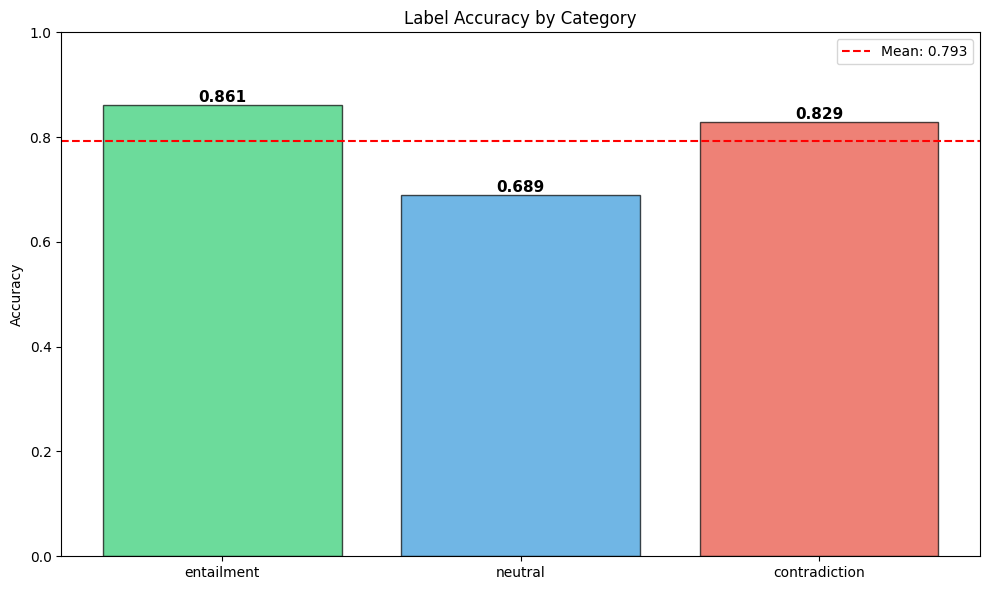

In [13]:
# Visualize per-label accuracy
if per_label_metrics:
    labels = list(per_label_metrics.keys())
    accuracies = [per_label_metrics[label].get('label_accuracy', 0) 
                  for label in labels]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bars = ax.bar(labels, accuracies, color=colors, alpha=0.7, edgecolor='black')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Label Accuracy by Category')
    ax.set_ylim(0, 1.0)
    ax.axhline(y=float(np.mean(accuracies)), color='red', linestyle='--', 
               label=f'Mean: {np.mean(accuracies):.3f}')
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.legend()
    plt.tight_layout()
    plt.show()

## 7. Compare Metrics Across Labels

METRICS COMPARISON ACROSS LABELS

         label  label_accuracy   rouge1   rouge2   rougeL  faithfulness
   entailment        0.861342 0.492642 0.291518 0.434052      0.871734
      neutral        0.688626 0.423163 0.216106 0.374120      0.265071
contradiction        0.829177 0.468235 0.243735 0.399920      0.779925


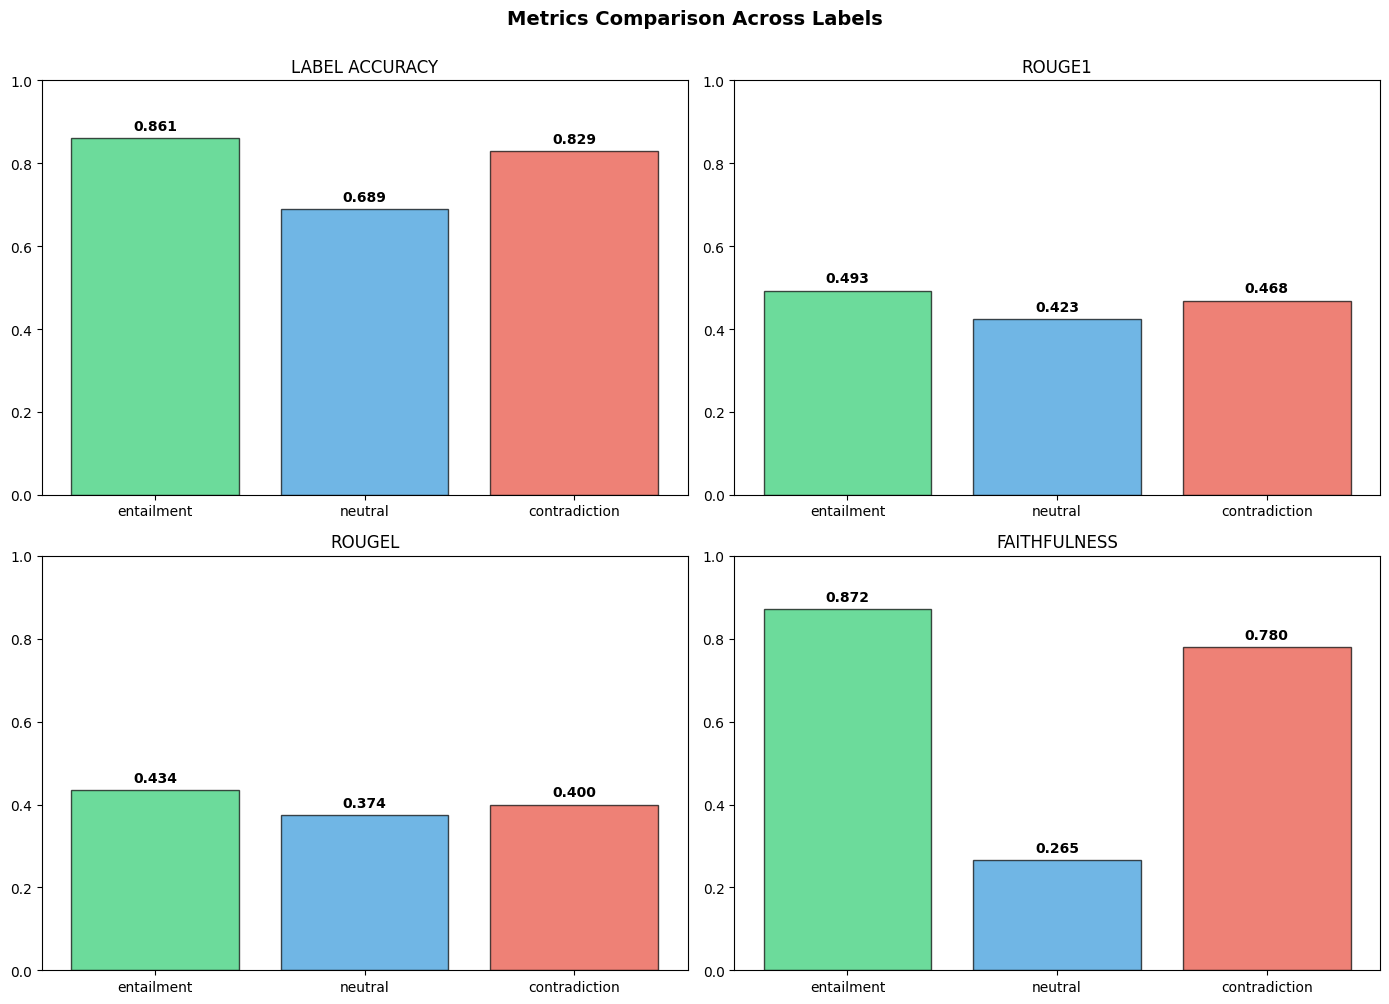

In [14]:
# Create comparison DataFrame
if per_label_metrics:
    print("=" * 70)
    print("METRICS COMPARISON ACROSS LABELS")
    print("=" * 70)
    
    # Extract common metrics
    metric_names = ['label_accuracy', 'rouge1', 'rouge2', 'rougeL', 'faithfulness']
    
    comparison_data = []
    for label in labels:
        row: dict = {'label': label}
        for metric in metric_names:
            row[metric] = float(per_label_metrics[label].get(metric, 0))
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n", comparison_df.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    metrics_to_plot = ['label_accuracy', 'rouge1', 'rougeL', 'faithfulness']
    
    for idx, metric in enumerate(metrics_to_plot):
        values = comparison_df[metric].values
        axes[idx].bar(labels, values, color=colors, alpha=0.7, edgecolor='black')
        axes[idx].set_title(metric.upper().replace('_', ' '))
        axes[idx].set_ylim(0, 1.0)
        
        # Add values
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.02, f'{v:.3f}', 
                          ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Metrics Comparison Across Labels', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

## 9. Distillation vs Baseline Comparison

Compare the **distilled model** (β=0.5, trained with teacher guidance) against the **baseline model** (β=0.0, no distillation).

This comparison demonstrates the **value added by knowledge distillation**.

| Model | Training | Distill Weight (β) |
|-------|----------|-------------------|
| Distilled | With teacher | β = 0.5 |
| Baseline | No teacher | β = 0.0 |

In [15]:
# ============================================================
# DISTILLATION vs BASELINE COMPARISON
# ============================================================
print("=" * 70)
print("DISTILLATION vs BASELINE COMPARISON")
print("=" * 70)

batch_evaluator = BatchEvaluator(
    output_dir="../experiments/distillation_vs_baseline"
)

# ============================================================
# Model 1: DISTILLED (β=0.5, with teacher guidance)
# ============================================================
print("\n" + "-" * 70)
print("Loading Model 1: DISTILLED (β=0.5)")
print("-" * 70)

# The distilled model is already loaded as 'student' from checkpoint
# (loaded earlier in the notebook from experiments/distillation/best_model)
print(f"✓ Distilled model already loaded from: experiments/distillation/best_model")
print(f"  Parameters: {student.count_parameters():,}")

# Create evaluator for distilled model
eval_config_distilled = EvaluationConfig(
    metrics_config=MetricsConfig(
        compute_rouge=True,
        compute_bertscore=False,
        compute_faithfulness=True
    ),
    num_beams=4,
    max_length=64,
    save_predictions=True,
    save_detailed_results=True,
    analyze_errors=True,
    num_error_examples=5,
    output_dir="../experiments/eval_distilled"
)

evaluator_distilled = Evaluator(student, eval_config_distilled)

# Add distilled model evaluation
print("\nEvaluating Distilled Model...")
batch_evaluator.add_evaluation(
    "FLAN-T5-small (Distilled, β=0.5)",
    evaluator_distilled,
    test_loader
)

# ============================================================
# Model 2: BASELINE (β=0.0, no teacher guidance)
# ============================================================
print("\n" + "-" * 70)
print("Loading Model 2: BASELINE (β=0.0)")
print("-" * 70)

# Load baseline model from checkpoint
baseline_dir = Path("../experiments/baseline/best_model")
baseline_zip = Path("../experiments/baseline/best_model.zip")

# Extract if needed
if baseline_zip.exists() and not baseline_dir.exists():
    print(f"Extracting baseline model from {baseline_zip}...")
    with zipfile.ZipFile(baseline_zip, 'r') as zip_ref:
        zip_ref.extractall(Path("../experiments/baseline"))
    print("✓ Extracted successfully")

if baseline_dir.exists():
    # Load baseline model
    student_config_baseline = StudentConfig(
        model_name="google/flan-t5-small",
        max_source_length=128,
        max_target_length=64,
        device=device,
        num_beams=4
    )
    
    student_baseline = StudentModel.load_model(str(baseline_dir), student_config_baseline)
    print(f"✓ Baseline model loaded from: {baseline_dir}")
    print(f"  Parameters: {student_baseline.count_parameters():,}")
    
    # Create evaluator for baseline model
    eval_config_baseline = EvaluationConfig(
        metrics_config=MetricsConfig(
            compute_rouge=True,
            compute_bertscore=False,
            compute_faithfulness=True
        ),
        num_beams=4,
        max_length=64,
        save_predictions=True,
        save_detailed_results=True,
        analyze_errors=True,
        num_error_examples=5,
        output_dir="../experiments/eval_baseline"
    )
    
    evaluator_baseline = Evaluator(student_baseline, eval_config_baseline)
    
    # Add baseline model evaluation
    print("\nEvaluating Baseline Model...")
    batch_evaluator.add_evaluation(
        "FLAN-T5-small (Baseline, β=0.0)",
        evaluator_baseline,
        test_loader
    )
else:
    print(f"\n⚠️ Baseline model not found at: {baseline_dir}")
    print(f"   Please run notebook 06.1_baseline_training.ipynb first!")

# ============================================================
# Display Results
# ============================================================
print("\n" + "=" * 70)
print("COMPARISON RESULTS: DISTILLATION vs BASELINE")
print("=" * 70)

for result in batch_evaluator.results:
    print(f"\n{'='*50}")
    print(f"Model: {result['model_name']}")
    print(f"{'='*50}")
    print(format_metrics(result['metrics']))


INFO:src.evaluation.evaluator:Evaluator initialized with output dir: ../experiments/eval_distilled
INFO:src.evaluation.evaluator:Evaluating FLAN-T5-small (Distilled, β=0.5)...
INFO:src.evaluation.evaluator:Starting evaluation on FLAN-T5-small (Distilled, β=0.5) split...
INFO:src.evaluation.evaluator:Total batches: 1228


DISTILLATION vs BASELINE COMPARISON

----------------------------------------------------------------------
Loading Model 1: DISTILLED (β=0.5)
----------------------------------------------------------------------
✓ Distilled model already loaded from: experiments/distillation/best_model
  Parameters: 76,961,152

Evaluating Distilled Model...


Evaluating FLAN-T5-small (Distilled, β=0.5): 100%|██████████| 1228/1228 [11:43<00:00,  1.74it/s]
INFO:src.evaluation.evaluator:Generation complete in 703.78s
INFO:src.evaluation.evaluator:Generated 9824 predictions
INFO:src.evaluation.evaluator:Computing metrics...
INFO:absl:Using default tokenizer.
INFO:src.evaluation.evaluator:Analyzing errors...
INFO:src.evaluation.evaluator:Saved metrics to ../experiments/eval_distilled/FLAN-T5-small (Distilled, β=0.5)_metrics.json
INFO:src.evaluation.evaluator:Saved predictions to ../experiments/eval_distilled/FLAN-T5-small (Distilled, β=0.5)_predictions.jsonl
INFO:src.evaluation.evaluator:Saved error analysis to ../experiments/eval_distilled/FLAN-T5-small (Distilled, β=0.5)_analysis.json
INFO:src.evaluation.evaluator:
INFO:src.evaluation.evaluator:Evaluation Results - FLAN-T5-small (Distilled, β=0.5)
INFO:src.evaluation.evaluator:======================================================================
INFO:src.evaluation.evaluator:  accuracy_contra


----------------------------------------------------------------------
Loading Model 2: BASELINE (β=0.0)
----------------------------------------------------------------------
✓ Baseline model loaded from: ../experiments/baseline/best_model
  Parameters: 76,961,152

Evaluating Baseline Model...


Evaluating FLAN-T5-small (Baseline, β=0.0): 100%|██████████| 1228/1228 [11:24<00:00,  1.79it/s]
INFO:src.evaluation.evaluator:Generation complete in 684.56s
INFO:src.evaluation.evaluator:Generated 9824 predictions
INFO:src.evaluation.evaluator:Computing metrics...
INFO:absl:Using default tokenizer.
INFO:src.evaluation.evaluator:Analyzing errors...
INFO:src.evaluation.evaluator:Saved metrics to ../experiments/eval_baseline/FLAN-T5-small (Baseline, β=0.0)_metrics.json
INFO:src.evaluation.evaluator:Saved predictions to ../experiments/eval_baseline/FLAN-T5-small (Baseline, β=0.0)_predictions.jsonl
INFO:src.evaluation.evaluator:Saved error analysis to ../experiments/eval_baseline/FLAN-T5-small (Baseline, β=0.0)_analysis.json
INFO:src.evaluation.evaluator:
INFO:src.evaluation.evaluator:Evaluation Results - FLAN-T5-small (Baseline, β=0.0)
INFO:src.evaluation.evaluator:======================================================================
INFO:src.evaluation.evaluator:  accuracy_contradiction:


COMPARISON RESULTS: DISTILLATION vs BASELINE

Model: FLAN-T5-small (Distilled, β=0.5)
  accuracy_contradiction: 0.8292
  accuracy_entailment: 0.8613
  accuracy_neutral: 0.6886
  eval_time_seconds: 703.7792
  faithfulness: 0.6423
  label_accuracy: 0.7941
  loss: 1.2048
  rouge1: 0.4618
  rouge2: 0.2511
  rougeL: 0.4032
  samples_per_second: 13.9589
  valid_predictions: 9794

Model: FLAN-T5-small (Baseline, β=0.0)
  accuracy_contradiction: 0.7884
  accuracy_entailment: 0.8331
  accuracy_neutral: 0.7499
  eval_time_seconds: 684.5644
  faithfulness: 0.6008
  label_accuracy: 0.7911
  loss: 1.1553
  rouge1: 0.4628
  rouge2: 0.2491
  rougeL: 0.4046
  samples_per_second: 14.3507
  valid_predictions: 9824



DISTILLATION vs BASELINE VISUALIZATION


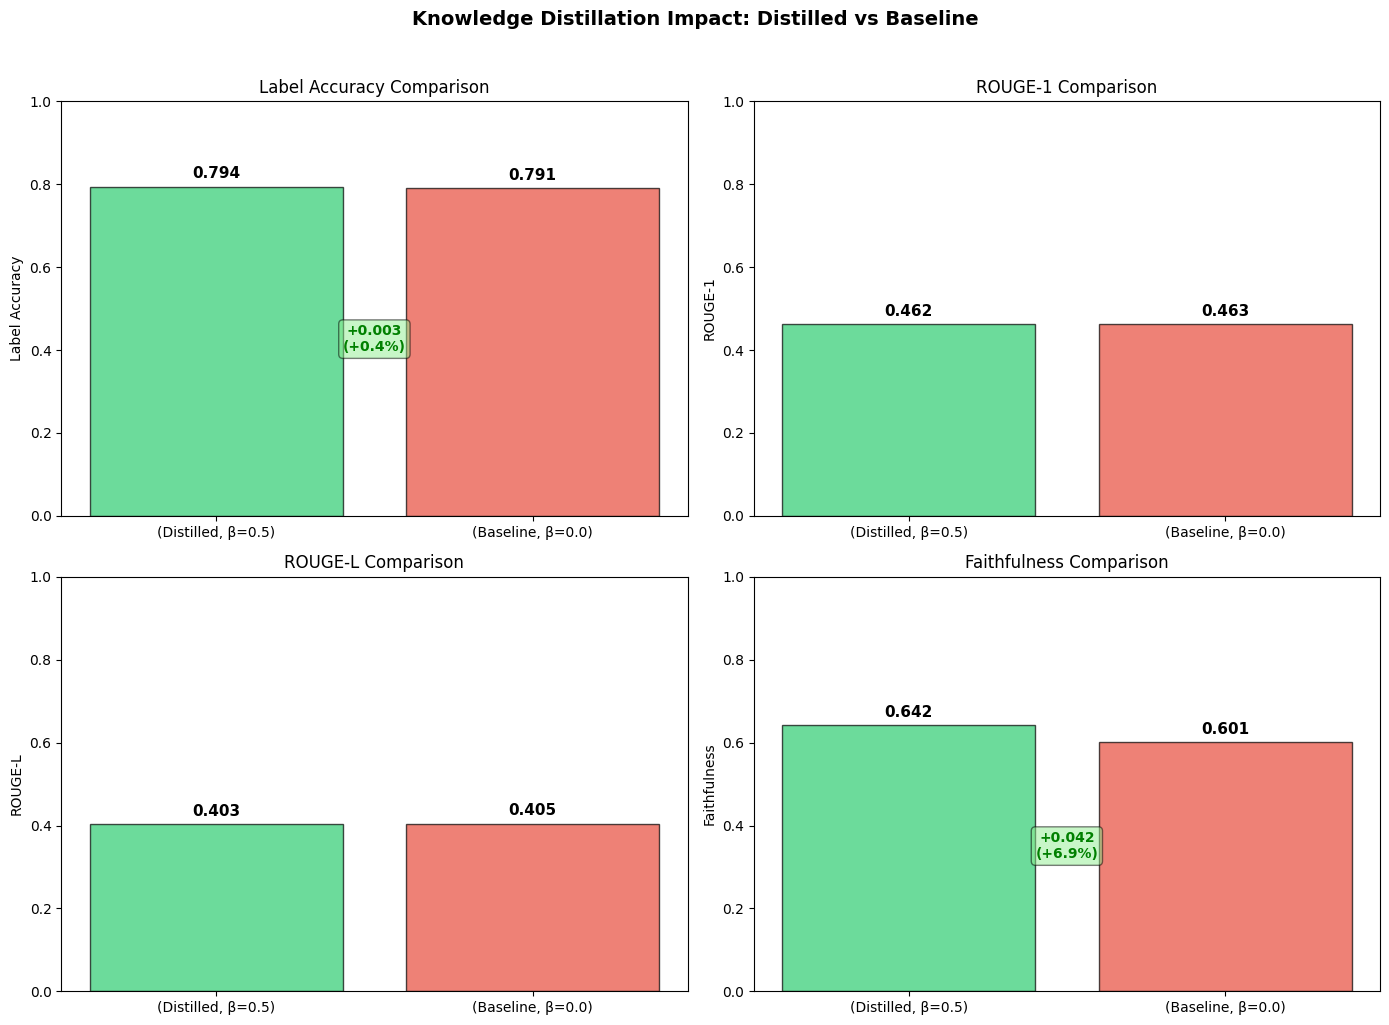


DISTILLATION IMPROVEMENT ANALYSIS

Metric                  Distilled     Baseline   Δ Absolute   Δ Relative
----------------------------------------------------------------------
Accuracy                   0.7941       0.7911           +0.0029           +0.4%
ROUGE-1                    0.4618       0.4628            -0.0009            -0.2%
ROUGE-2                    0.2511       0.2491           +0.0019           +0.8%
ROUGE-L                    0.4032       0.4046            -0.0014            -0.4%
Faithfulness               0.6423       0.6008           +0.0416           +6.9%

CONCLUSION:

✓ Knowledge Distillation IMPROVES performance!
  Accuracy gain: +0.0029 (0.4%)


In [16]:
# ============================================================
# VISUALIZE DISTILLATION vs BASELINE
# ============================================================
if len(batch_evaluator.results) >= 2:
    print("\n" + "=" * 70)
    print("DISTILLATION vs BASELINE VISUALIZATION")
    print("=" * 70)
    
    # Extract metrics
    models = [r['model_name'].replace('FLAN-T5-small ', '') for r in batch_evaluator.results]
    accuracy_scores = [r['metrics'].get('label_accuracy', 0) for r in batch_evaluator.results]
    rouge1_scores = [r['metrics'].get('rouge1', 0) for r in batch_evaluator.results]
    rougeL_scores = [r['metrics'].get('rougeL', 0) for r in batch_evaluator.results]
    faithfulness_scores = [r['metrics'].get('faithfulness', 0) for r in batch_evaluator.results]
    
    # Colors: Green for Distilled, Red for Baseline
    colors = ['#2ecc71', '#e74c3c']
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    metrics_data = [
        ('Label Accuracy', accuracy_scores),
        ('ROUGE-1', rouge1_scores),
        ('ROUGE-L', rougeL_scores),
        ('Faithfulness', faithfulness_scores)
    ]
    
    for idx, (metric_name, scores) in enumerate(metrics_data):
        bars = axes[idx].bar(models, scores, color=colors, alpha=0.7, edgecolor='black')
        axes[idx].set_ylabel(metric_name)
        axes[idx].set_title(f'{metric_name} Comparison')
        axes[idx].set_ylim(0, 1.0)
        
        # Add value labels
        for i, v in enumerate(scores):
            axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold', fontsize=11)
        
        # Add improvement annotation if distilled > baseline
        if len(scores) >= 2 and scores[0] > scores[1]:
            improvement = scores[0] - scores[1]
            pct_improvement = (improvement / scores[1]) * 100 if scores[1] > 0 else 0
            axes[idx].annotate(
                f'+{improvement:.3f}\n(+{pct_improvement:.1f}%)',
                xy=(0.5, max(scores) * 0.5),
                fontsize=10,
                ha='center',
                color='green',
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.5)
            )
    
    plt.suptitle('Knowledge Distillation Impact: Distilled vs Baseline', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ============================================================
    # CALCULATE IMPROVEMENT
    # ============================================================
    print("\n" + "=" * 70)
    print("DISTILLATION IMPROVEMENT ANALYSIS")
    print("=" * 70)
    
    if len(batch_evaluator.results) >= 2:
        distilled_metrics = batch_evaluator.results[0]['metrics']
        baseline_metrics = batch_evaluator.results[1]['metrics']
        
        print("\n{:<20} {:>12} {:>12} {:>12} {:>12}".format(
            'Metric', 'Distilled', 'Baseline', 'Δ Absolute', 'Δ Relative'))
        print("-" * 70)
        
        metrics_to_compare = [
            ('label_accuracy', 'Accuracy'),
            ('rouge1', 'ROUGE-1'),
            ('rouge2', 'ROUGE-2'),
            ('rougeL', 'ROUGE-L'),
            ('faithfulness', 'Faithfulness')
        ]
        
        for metric_key, metric_name in metrics_to_compare:
            dist_val = distilled_metrics.get(metric_key, 0)
            base_val = baseline_metrics.get(metric_key, 0)
            abs_diff = dist_val - base_val
            rel_diff = (abs_diff / base_val * 100) if base_val > 0 else 0
            
            sign = '+' if abs_diff >= 0 else ''
            print("{:<20} {:>12.4f} {:>12.4f} {:>11}{:.4f} {:>11}{:.1f}%".format(
                metric_name, dist_val, base_val, sign, abs_diff, sign, rel_diff))
        
        print("\n" + "=" * 70)
        print("CONCLUSION:")
        print("=" * 70)
        
        acc_improvement = distilled_metrics.get('label_accuracy', 0) - baseline_metrics.get('label_accuracy', 0)
        if acc_improvement > 0:
            print(f"\n✓ Knowledge Distillation IMPROVES performance!")
            print(f"  Accuracy gain: +{acc_improvement:.4f} ({acc_improvement/baseline_metrics.get('label_accuracy', 1)*100:.1f}%)")
        elif acc_improvement < 0:
            print(f"\n✗ Knowledge Distillation shows NEGATIVE impact")
            print(f"  (This may indicate training issues or suboptimal hyperparameters)")
        else:
            print(f"\n≈ Knowledge Distillation shows NO significant difference")


In [17]:
# ============================================================
# SAVE COMPARISON REPORT
# ============================================================
print("\n" + "=" * 70)
print("SAVING COMPARISON REPORT")
print("=" * 70)

# Create summary DataFrame
report_data = []
for result in batch_evaluator.results:
    metrics = result['metrics']
    row = {
        'Model': result['model_name'],
        'Training': 'Distilled (β=0.5)' if 'Distilled' in result['model_name'] else 'Baseline (β=0.0)',
        'Accuracy': metrics.get('label_accuracy', 0),
        'ROUGE1': metrics.get('rouge1', 0),
        'ROUGE2': metrics.get('rouge2', 0),
        'ROUGEL': metrics.get('rougeL', 0),
        'Faithfulness': metrics.get('faithfulness', 0),
        'Eval Time (s)': metrics.get('eval_time_seconds', 0),
        'Throughput (samples/s)': metrics.get('samples_per_second', 0)
    }
    report_data.append(row)

report_df = pd.DataFrame(report_data)

# Save as CSV
output_path = Path("../experiments/distillation_vs_baseline")
output_path.mkdir(parents=True, exist_ok=True)

csv_path = output_path / "distillation_vs_baseline_comparison.csv"
report_df.to_csv(csv_path, index=False)

print(f"\n✓ Report saved to: {csv_path}")
print("\n" + "=" * 70)
print("FINAL COMPARISON TABLE")
print("=" * 70)
print("\n" + report_df.to_string(index=False))

# ============================================================
# SUMMARY
# ============================================================
if len(batch_evaluator.results) >= 2:
    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)
    
    dist = batch_evaluator.results[0]['metrics']
    base = batch_evaluator.results[1]['metrics']
    
    summary_table = """
    | Model                | Accuracy | ROUGE-L | Faithfulness |
    |----------------------|----------|---------|--------------|
    | Baseline (β=0.0)     | {:.4f}   | {:.4f}  | {:.4f}       |
    | Distilled (β=0.5)    | {:.4f}   | {:.4f}  | {:.4f}       |
    | **Improvement**      | {:+.4f}  | {:+.4f} | {:+.4f}      |
    """.format(
        base.get('label_accuracy', 0), base.get('rougeL', 0), base.get('faithfulness', 0),
        dist.get('label_accuracy', 0), dist.get('rougeL', 0), dist.get('faithfulness', 0),
        dist.get('label_accuracy', 0) - base.get('label_accuracy', 0),
        dist.get('rougeL', 0) - base.get('rougeL', 0),
        dist.get('faithfulness', 0) - base.get('faithfulness', 0)
    )
    
    print(summary_table)



SAVING COMPARISON REPORT

✓ Report saved to: ../experiments/distillation_vs_baseline/distillation_vs_baseline_comparison.csv

FINAL COMPARISON TABLE

                           Model          Training  Accuracy   ROUGE1   ROUGE2   ROUGEL  Faithfulness  Eval Time (s)  Throughput (samples/s)
FLAN-T5-small (Distilled, β=0.5) Distilled (β=0.5)  0.794058 0.461834 0.251064 0.403168      0.642332     703.779183               13.958924
 FLAN-T5-small (Baseline, β=0.0)  Baseline (β=0.0)  0.791124 0.462761 0.249150 0.404610      0.600774     684.564392               14.350732

SUMMARY

    | Model                | Accuracy | ROUGE-L | Faithfulness |
    |----------------------|----------|---------|--------------|
    | Baseline (β=0.0)     | 0.7911   | 0.4046  | 0.6008       |
    | Distilled (β=0.5)    | 0.7941   | 0.4032  | 0.6423       |
    | **Improvement**      | +0.0029  | -0.0014 | +0.0416      |
    
